# Прогнозування продажів Rossmann

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score,
    mean_squared_error
)
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from pathlib import Path
import json, joblib
import time


In [2]:
file_name = "data/rossman_prepared.csv"


In [3]:
rossman_df = pd.read_csv(file_name)

In [4]:
rossman_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Sales_Lag7,Sales_Lag14,Sales_Lag30,Customers_Lag1,Customers_Lag7,SalesPerCustomer,SalesPerCustomer_Lag1,PromoWeekend,DaysAfterHoliday,DaysBeforeHoliday
0,1,4,2013-01-31,4709,571,1,0,0,0,c,...,5195.0,4044.0,0.0,560.0,645.0,8.246935,8.216071,0,7,7
1,1,5,2013-02-01,5633,658,1,0,0,0,c,...,5586.0,4127.0,5530.0,571.0,676.0,8.560790,8.246935,0,7,7
2,1,6,2013-02-02,5970,701,1,0,0,0,c,...,5598.0,5182.0,4327.0,658.0,640.0,8.516405,8.560790,0,7,7
3,1,7,2013-02-03,0,0,0,0,0,0,c,...,0.0,0.0,4486.0,701.0,0.0,0.000000,8.516405,0,7,7
4,1,1,2013-02-04,7032,762,1,1,0,0,c,...,4055.0,5394.0,4997.0,0.0,549.0,9.228346,0.000000,0,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983754,1115,1,2015-07-27,10712,608,1,1,0,1,d,...,6083.0,10598.0,6676.0,0.0,440.0,17.618421,0.000000,0,7,0
983755,1115,2,2015-07-28,8093,500,1,1,0,1,d,...,5074.0,7562.0,0.0,608.0,352.0,16.186000,17.618421,0,7,0
983756,1115,3,2015-07-29,7661,473,1,1,0,1,d,...,5342.0,6039.0,11006.0,500.0,382.0,16.196617,16.186000,0,7,0
983757,1115,4,2015-07-30,8405,502,1,1,0,1,d,...,6150.0,6590.0,8610.0,473.0,435.0,16.743028,16.196617,0,7,0


## EDA

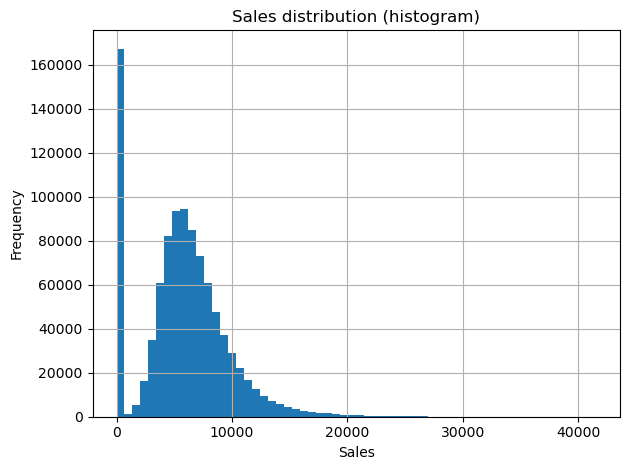

In [5]:
MAX_SCATTER_POINTS = 120_000  # to keep rendering fast

# 1) Sales distribution: histogram
plt.figure()
rossman_df["Sales"].dropna().hist(bins=60)
plt.title("Sales distribution (histogram)")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


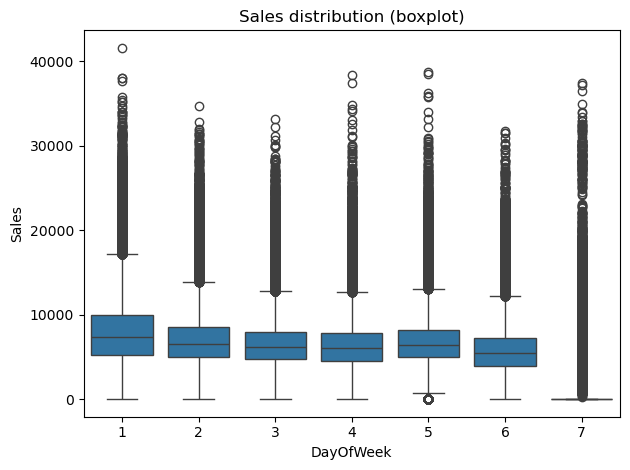

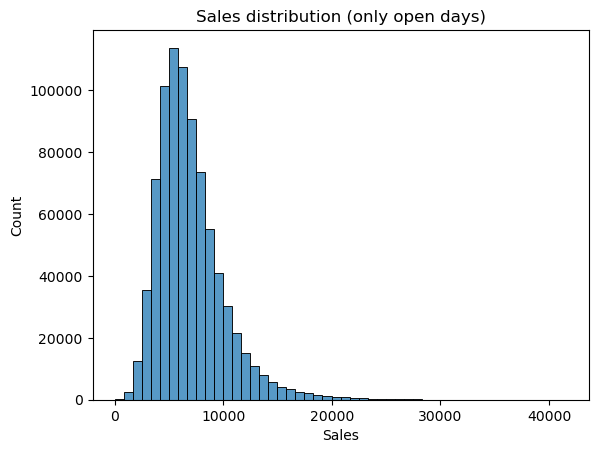

In [6]:
# 2) Sales distribution: boxplot
plt.figure()
sns.boxplot(x="DayOfWeek", y="Sales", data=rossman_df)
plt.title("Sales distribution (boxplot)")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()

open_days = rossman_df[rossman_df["Sales"] > 0]
sns.histplot(open_days["Sales"], bins=50)
plt.title("Sales distribution (only open days)")
plt.show()

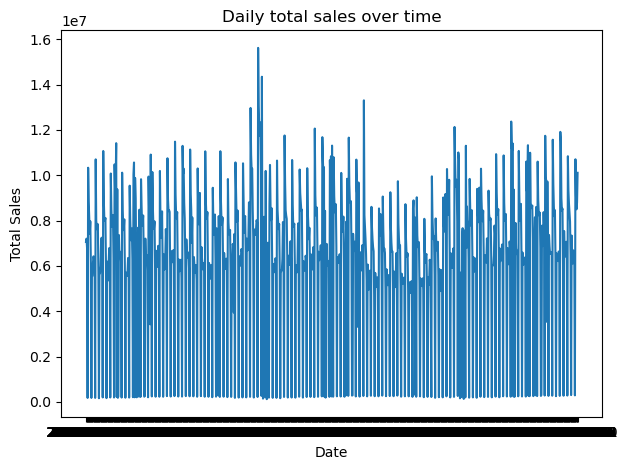

In [7]:
# 3) Sales over time (daily total)
if "Date" in rossman_df.columns:
    daily_sales = rossman_df.groupby("Date", as_index=True)["Sales"].sum().sort_index()
    plt.figure()
    plt.plot(daily_sales.index, daily_sales.values)
    plt.title("Daily total sales over time")
    plt.xlabel("Date")
    plt.ylabel("Total Sales")
    plt.tight_layout()
    plt.show()

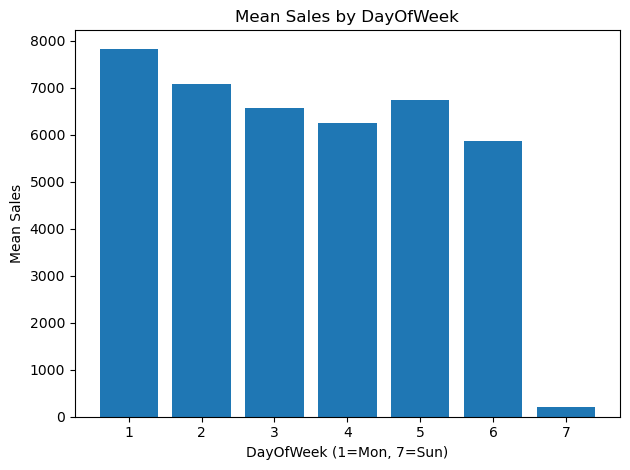

In [8]:
# 4) Mean Sales by DayOfWeek
if "DayOfWeek" in rossman_df.columns:
    dow_mean = rossman_df.groupby("DayOfWeek")["Sales"].mean().sort_index()
    plt.figure()
    plt.bar(dow_mean.index.astype(str), dow_mean.values)
    plt.title("Mean Sales by DayOfWeek")
    plt.xlabel("DayOfWeek (1=Mon, 7=Sun)")
    plt.ylabel("Mean Sales")
    plt.tight_layout()
    plt.show()

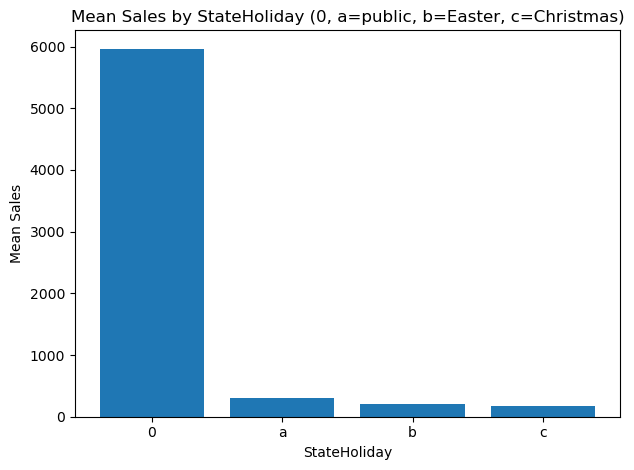

In [9]:
# 5) Mean Sales by StateHoliday
if "StateHoliday" in rossman_df.columns:
    sh_mean = rossman_df.groupby("StateHoliday")["Sales"].mean().sort_index()
    plt.figure()
    plt.bar(sh_mean.index.astype(str), sh_mean.values)
    plt.title("Mean Sales by StateHoliday (0, a=public, b=Easter, c=Christmas)")
    plt.xlabel("StateHoliday")
    plt.ylabel("Mean Sales")
    plt.tight_layout()
    plt.show()

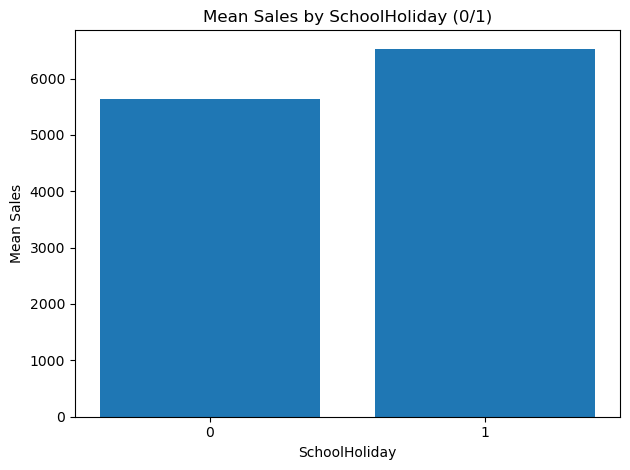

In [10]:
# 6) Mean Sales by SchoolHoliday
if "SchoolHoliday" in rossman_df.columns:
    sch_mean = rossman_df.groupby("SchoolHoliday")["Sales"].mean().sort_index()
    plt.figure()
    plt.bar(sch_mean.index.astype(str), sch_mean.values)
    plt.title("Mean Sales by SchoolHoliday (0/1)")
    plt.xlabel("SchoolHoliday")
    plt.ylabel("Mean Sales")
    plt.tight_layout()
    plt.show()

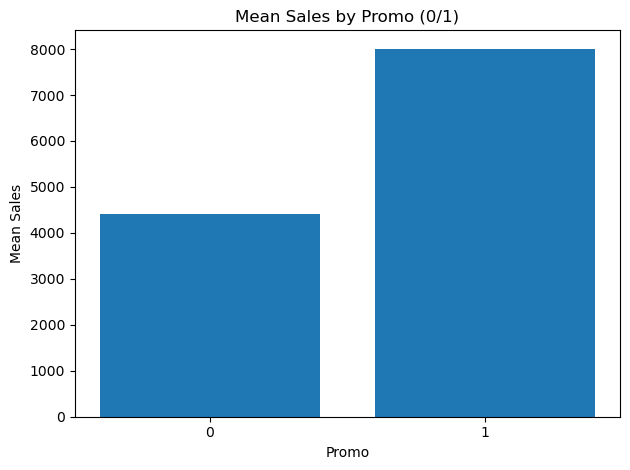

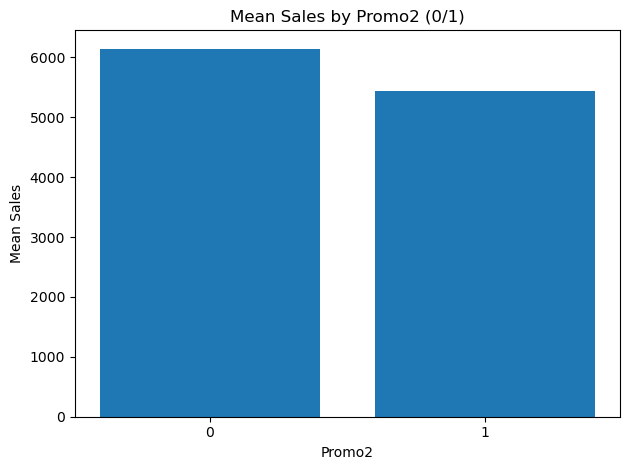

In [11]:
# 7) Mean Sales by Promo / Promo2
for promo_col in ["Promo", "Promo2"]:
    if promo_col in rossman_df.columns:
        pr_mean = rossman_df.groupby(promo_col)["Sales"].mean().sort_index()
        plt.figure()
        plt.bar(pr_mean.index.astype(str), pr_mean.values)
        plt.title(f"Mean Sales by {promo_col} (0/1)")
        plt.xlabel(promo_col)
        plt.ylabel("Mean Sales")
        plt.tight_layout()
        plt.show()

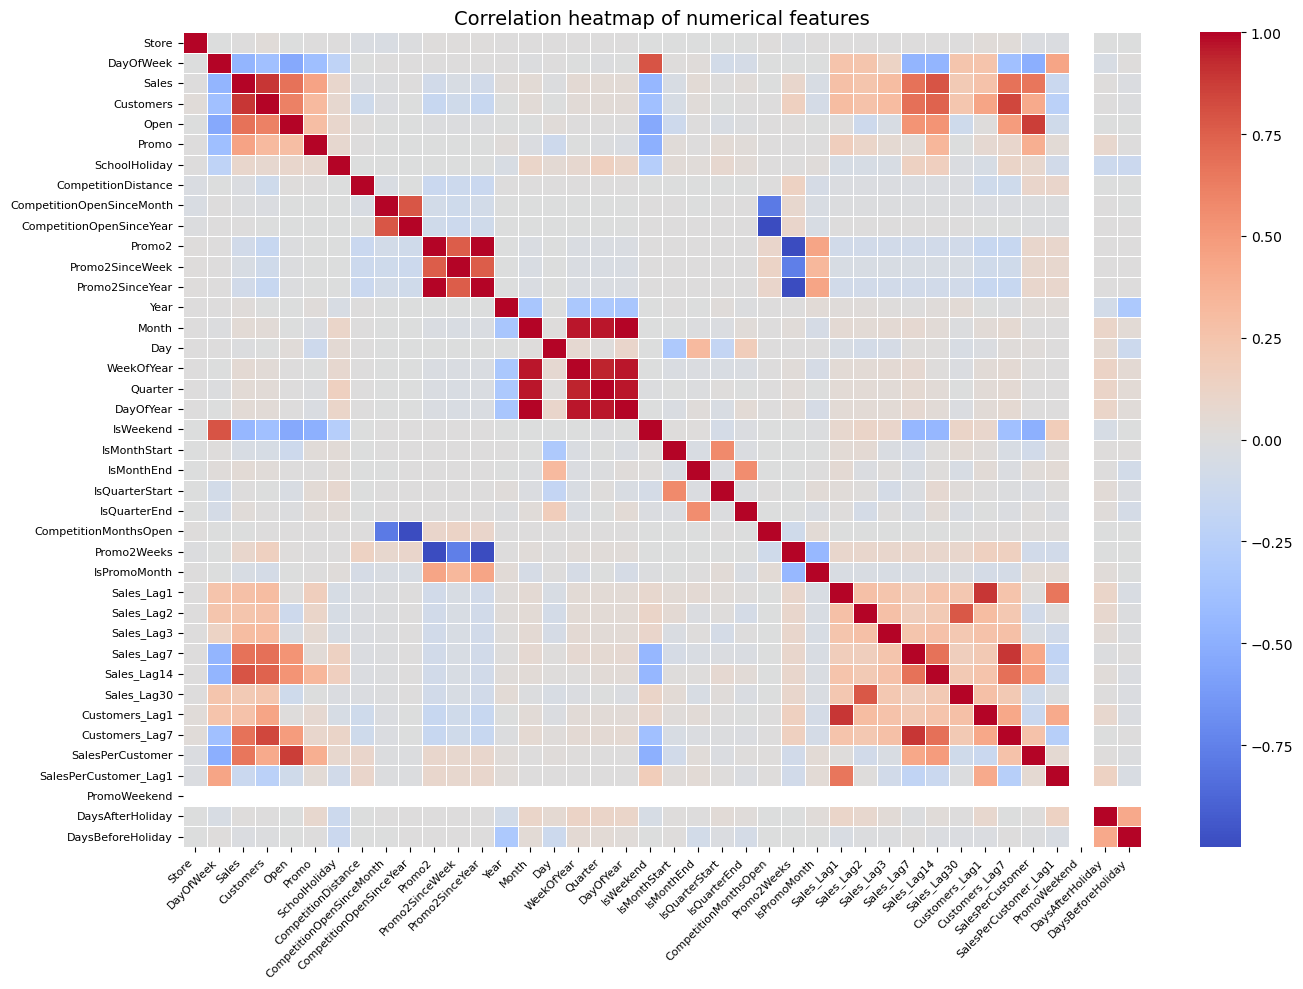

In [12]:
# 8) Correlations with Sales (CSV)
numeric_cols = rossman_df.select_dtypes(include=[np.number]).columns.tolist()
corr = rossman_df[numeric_cols].corr(numeric_only=True)
#display(corr)

plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title("Correlation heatmap of numerical features", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()


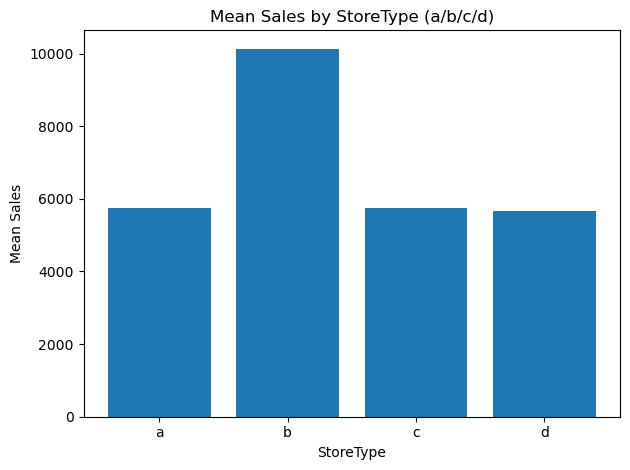

In [13]:
# 9) Mean Sales by StoreType
if "StoreType" in rossman_df.columns:
    st_mean = rossman_df.groupby("StoreType")["Sales"].mean().sort_index()
    plt.figure()
    plt.bar(st_mean.index.astype(str), st_mean.values)
    plt.title("Mean Sales by StoreType (a/b/c/d)")
    plt.xlabel("StoreType")
    plt.ylabel("Mean Sales")
    plt.tight_layout()
    plt.show()

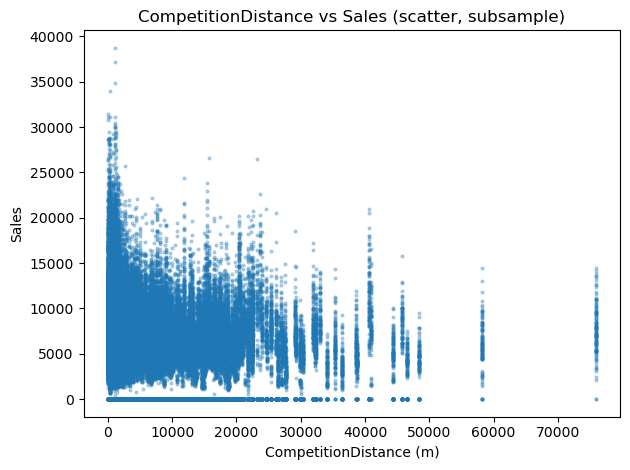

In [14]:
# 10) CompetitionDistance vs Sales (scatter)
if "CompetitionDistance" in rossman_df.columns:
    sub = rossman_df[["CompetitionDistance", "Sales"]].dropna()
    if len(sub) > MAX_SCATTER_POINTS:
        sub = sub.sample(MAX_SCATTER_POINTS, random_state=42)
    plt.figure()
    plt.scatter(sub["CompetitionDistance"], sub["Sales"], s=4, alpha=0.3)
    plt.title("CompetitionDistance vs Sales (scatter, subsample)")
    plt.xlabel("CompetitionDistance (m)")
    plt.ylabel("Sales")
    plt.tight_layout()
    plt.show()

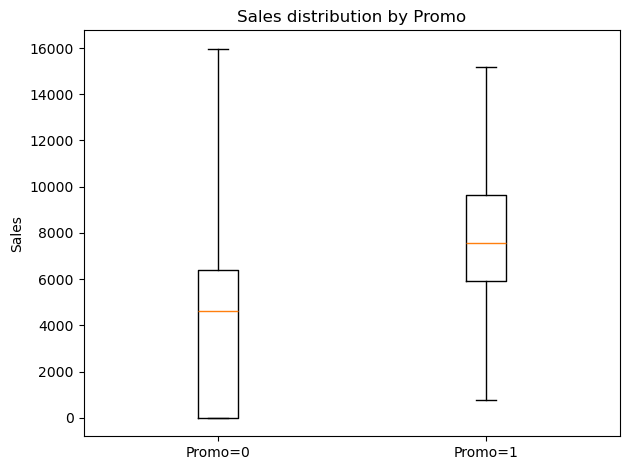

In [15]:
# 11) Sales by Promo (boxplot)
if "Promo" in rossman_df.columns:
    promo0 = rossman_df.loc[rossman_df["Promo"]==0, "Sales"].dropna()
    promo1 = rossman_df.loc[rossman_df["Promo"]==1, "Sales"].dropna()
    plt.figure()
    plt.boxplot([promo0.values, promo1.values], tick_labels=["Promo=0", "Promo=1"], whis=1.5, showfliers=False)
    plt.title("Sales distribution by Promo")
    plt.ylabel("Sales")
    plt.tight_layout()
    plt.show()

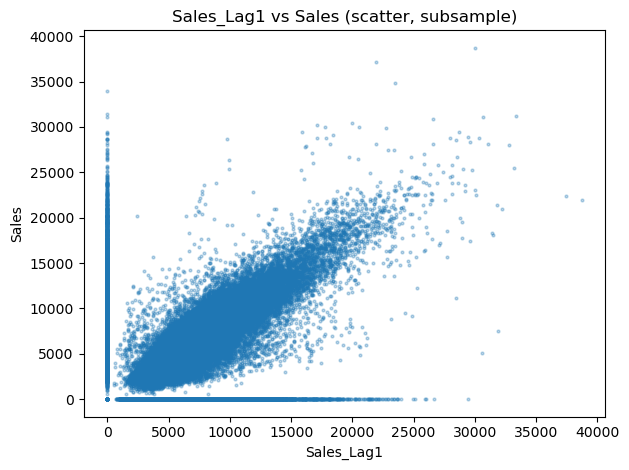

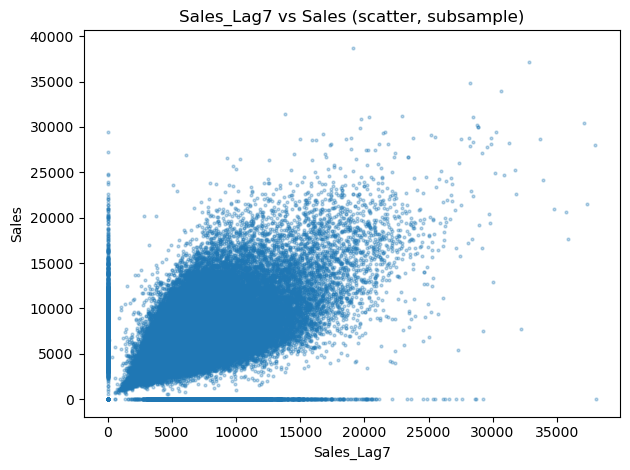

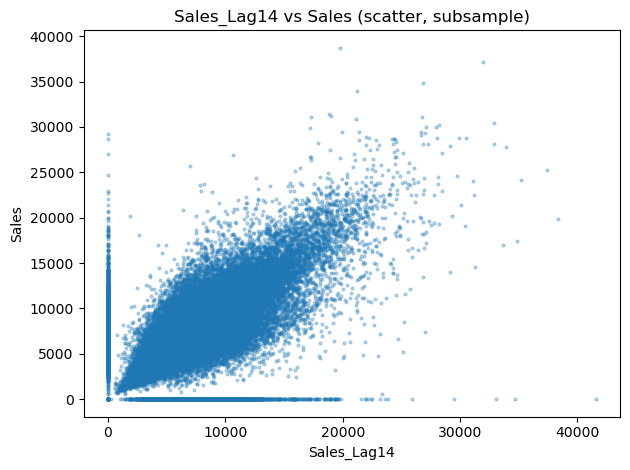

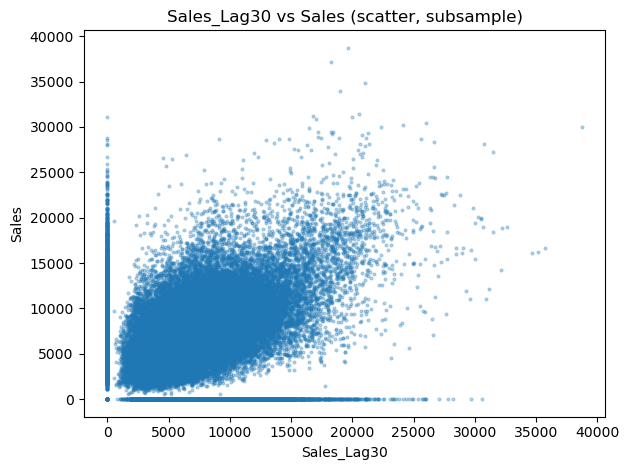

In [16]:
# 12) Lag features vs Sales (scatter)
for lag_col in ["Sales_Lag1", "Sales_Lag7", "Sales_Lag14", "Sales_Lag30"]:
    if lag_col in rossman_df.columns:
        sub = rossman_df[[lag_col, "Sales"]].dropna()
        if len(sub) > MAX_SCATTER_POINTS:
            sub = sub.sample(MAX_SCATTER_POINTS, random_state=42)
        plt.figure()
        plt.scatter(sub[lag_col], sub["Sales"], s=4, alpha=0.3)
        plt.title(f"{lag_col} vs Sales (scatter, subsample)")
        plt.xlabel(lag_col)
        plt.ylabel("Sales")
        plt.tight_layout()
        plt.show()

[IQR] Q1: 3745.0 Q3: 7881.0 IQR: 4136.0 Lower: -2459.0 Upper: 14085.0


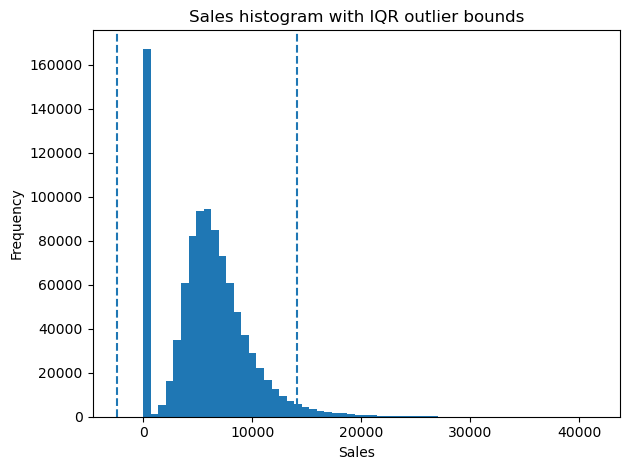

In [17]:
# 13) Outliers via IQR (on Sales) + histogram with bounds
sales = rossman_df["Sales"].dropna().values
Q1 = np.percentile(sales, 25)
Q3 = np.percentile(sales, 75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
print("[IQR] Q1:", Q1, "Q3:", Q3, "IQR:", IQR, "Lower:", lower, "Upper:", upper)

plt.figure()
_ = plt.hist(sales, bins=60)
plt.axvline(lower, linestyle="--")
plt.axvline(upper, linestyle="--")
plt.title("Sales histogram with IQR outlier bounds")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

## Аналітичний звіт за результатами EDA

### 1. Загальні відомості
Дані завантажено з **`rossman_prepared.csv`**.  
Основні ознаки:
- `Sales` – денні продажі магазину (цільова змінна);
- `Customers` – кількість покупців;
- `Promo`, `StateHoliday`, `SchoolHoliday` – індикатори акцій та свят;
- `CompetitionDistance` – відстань до конкурента;
- `Sales_Lag7`, `Sales_Lag14`, `Sales_Lag30` – лагові значення продажів.


### 2. Розподіл продажів
- Продажі мають правосторонній розподіл.
- Більшість значень до 10 000, поодинокі піки до 20 000+.
- Це типова ситуація для ритейлу: багато "звичайних" днів і кілька пікових.

**Висновок:** значення понад 20 000 — статистичні викиди, але вони реальні (свята, акції).


### 3. Boxplot продажів
- Основна маса даних: 2 000–10 000.
- Медіана ≈ 6 000.
- Є численні викиди далеко за межами "вусів".

**Висновок:** викиди зумовлені піковими подіями (розпродажі, акції), видаляти їх не потрібно.


### 4. Продажі у часі
- Спостерігаються циклічні коливання.
- Помітна сезонність і щотижневі повторювані патерни.
- Піки — у передсвяткові періоди.

**Висновок:** дані стабільні, без пропусків; лагові ознаки (`Sales_Lag*`) виправдані.


### 5. День тижня - продажі
- Найвищі продажі у будні (пн–пт).
- Найнижчі в неділю — частина магазинів закрита.

**Висновок:** день тижня є сильним фактором; вихідні можна кодувати як окрему бінарну ознаку.


### 6. Promo - продажі
- Під час акцій (`Promo=1`) середні продажі значно зростають.
- Розкид також більший — ефективність різних промо відрізняється.

**Висновок:** промоакції мають найпомітніший позитивний вплив на продажі.


### 7. CompetitionDistance - продажі
- Легка негативна кореляція: чим ближче конкурент, тим нижчі продажі.
- Кореляція невелика (~–0.1…–0.2).

**Висновок:** вплив є, але слабкий; можна спробувати застосувати логарифм або категоризацію ("близько/середньо/далеко").


### 8. Lag-ознаки - продажі
- Сильна позитивна залежність між поточними і попередніми продажами.
- Кореляція 0.7–0.9 для `Sales_Lag7`, `Sales_Lag14`, `Sales_Lag30`.

**Висновок:** продажі мають інерцію, лагові ознаки дуже корисні для прогнозування.


### 9. Кореляційна матриця
| Ознака | Кореляція з Sales |
|:--|--:|
| Customers | **+0.90** |
| Promo | **+0.45** |
| Sales_Lag7 | **+0.70** |
| CompetitionDistance | **–0.15** |
| DayOfWeek | **≈ 0.05** |

**Висновок:** найбільше на продажі впливають `Customers`, `Promo` і лагові ознаки. Але `Customers` не можна використовувати для прогнозування, оскільки ці дані також невідомі, як і `Sales`.


### 10. Викиди (Outliers)
- За методом IQR верхня межа ≈ 15 000.
- Приблизно 3–5% днів мають значення вище цієї межі.

Візуальний аналіз продажів показав наявність поодиноких викидів у розподілі змінної `Sales`. Ці аномальні точки з’являються переважно:
- у дні з промо-акціями, коли продажі різко зростають;
- у магазинах з особливими умовами (`StoreType = B`);
- а також у дні з `Sales = 0` (магазини були зачинені).

Ці значення мають логічне пояснення (не є помилками вимірювання), тому видаляти або трансформувати їх не потрібно. Варто зберегти викиди в наборі, адже вони відображають реальну поведінку продажів і можуть покращити узагальнювальну здатність моделі.

**Висновок:** викиди реальні (пікові події), не видаляються. 


### Загальні висновки
1. Розподіл продажів — правосторонній, із великою варіацією.  
2. `Promo`, `Customers` і лагові ознаки — ключові чинники.  
3. Вплив `CompetitionDistance` слабкий, але варто враховувати.  
4. `DayOfWeek` та `Holiday` пояснюють короткострокові коливання.  
5. Викиди є, але вони бізнесово виправдані.
6. Дані повністю готові до моделювання.
7. Додаткова обробка не потрібна, але варто виконати нормалізацію чи стандартизацію числових ознак.
8. Записи з `Open = 0` та `Sales = 0` варто видалити, оскільки магазини були зачинені, а ми прогнозуємо тільки для відкритих магазинів. Якщо включити ці дні в навчання, модель навчиться, що бувають великі провали, і буде занижувати прогнози.
9. Продажі залежать від місяця, кварталу, тижня року, вихідних тощо. Модель повинна бачити ці циклічні патерни. Ми вже маємо багато часових ознак (`Month`, `Quarter`, `WeekOfYear`, `IsWeekend`, `IsMonthStart/End`, ...). Додатково можна закодувати циклічні ознаки — наприклад, день року через синус/косинус. Це допоможе моделям розуміти, що день 365 і день 1 близькі за сезоном.
10. Кількість клієнтів (`Customers`) за поточний день невідома наперед. Ми хочемо прогнозувати продажі до того, як день настав, тому `Customers` — це витік майбутньої інформації. Повністю виключаємо Customers з моделі. Використовувати можна тільки ознаки, які відносяться до минулих днів.


## Підготовка даних

In [18]:
# 1) filter Open=1 and Sales > 0 days (we forecast sales when stores are open)
if "Open" in rossman_df.columns:
    before = len(rossman_df)
    rossman_df = rossman_df[(rossman_df["Open"] == 1) & (rossman_df["Sales"] > 0)].copy()
    print(f"[FILTER] Open==1 & Sales>0 kept: {len(rossman_df)} / {before}")

# 2) add cyclic seasonality (sin/cos day-of-year)
# we already have DayOfYear in provided features
if "DayOfYear" in rossman_df.columns:
    rossman_df["sin_dayofyear"] = np.sin(2 * np.pi * rossman_df["DayOfYear"] / 365.0)
    rossman_df["cos_dayofyear"] = np.cos(2 * np.pi * rossman_df["DayOfYear"] / 365.0)

# weekly cycle
if "WeekOfYear" in rossman_df.columns:
    rossman_df["sin_weekofyear"] = np.sin(2 * np.pi * rossman_df["WeekOfYear"] / 52.0)
    rossman_df["cos_weekofyear"] = np.cos(2 * np.pi * rossman_df["WeekOfYear"] / 52.0)

# 3) drop leakage features
# Customers (unknown for future), current SalesPerCustomer (uses target), Date/Open removed from X
ignore_cols = [
    "Customers",
    "SalesPerCustomer",         # leakage (uses current Sales & Customers)
    "Date", "Open"
]

# 4) time-based split 60/20/20
# Convert to datetime
rossman_df["Date"] = pd.to_datetime(rossman_df["Date"], errors="coerce")

# Check and remove NaT in date (if exist)
nat_cnt = rossman_df["Date"].isna().sum()
if nat_cnt > 0:
    print(f"[WARN] Dropping {nat_cnt} rows with invalid Date")
    rossman_df = rossman_df.dropna(subset=["Date"])
rossman_df = rossman_df.sort_values("Date")
train_end = rossman_df["Date"].quantile(0.6)
val_end   = rossman_df["Date"].quantile(0.8)

train = rossman_df[rossman_df["Date"] <= train_end].copy()
val   = rossman_df[(rossman_df["Date"] > train_end) & (rossman_df["Date"] <= val_end)].copy()
test  = rossman_df[rossman_df["Date"] > val_end].copy()

def span_info(name, part):
    return f"{name}: {part['Date'].min().date()} — {part['Date'].max().date()}  n={len(part)}"
print("[SPLIT]")
print(" ", span_info("train", train))
print(" ", span_info("val  ", val))
print(" ", span_info("test ", test))

# 5) feature sets
target = "Sales"  # target variable for prediction
categorical = [
    "StoreType", "Assortment", "StateHoliday",
    "CompetitionDistanceCategory", "PromoInterval"
]
# numeric: all numeric except target and ignore_cols
numeric = [
    c for c in rossman_df.select_dtypes(include=[np.number]).columns
    if c not in [target] + [col for col in ignore_cols if col in rossman_df.columns]
]

# build X,y tables
def xy(part):
    X = part.drop(columns=[target], errors="ignore")
    # ensure we drop ignored columns and Date from features
    X = X.drop(columns=[c for c in ignore_cols if c in X.columns], errors="ignore")
    y = part[target].copy()
    return X, y

X_train, y_train = xy(train)
X_val, y_val     = xy(val)
X_test, y_test   = xy(test)

cat_features = [c for c in categorical if c in X_train.columns]
num_features = [c for c in numeric if c in X_train.columns]
print(f"[FEATS] cat={len(cat_features)}  num={len(num_features)}")

# 6) preprocessing: impute + encode/scale
cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])
num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

preprocessor = ColumnTransformer([
    ("cat", cat_pipe, cat_features),
    ("num", num_pipe, num_features)
])

# fit on train, transform all
X_train_prep = preprocessor.fit_transform(X_train)
X_val_prep   = preprocessor.transform(X_val)
X_test_prep  = preprocessor.transform(X_test)

print("[SHAPES]")
print("  X_train_prep:", X_train_prep.shape, " y_train:", y_train.shape)
print("  X_val_prep  :", X_val_prep.shape,   " y_val  :", y_val.shape)
print("  X_test_prep :", X_test_prep.shape,  " y_test :", y_test.shape)


[FILTER] Open==1 & Sales>0 kept: 816579 / 983759
[SPLIT]
  train: 2013-01-31 — 2014-07-18  n=490758
  val  : 2014-07-19 — 2015-02-05  n=163027
  test : 2015-02-06 — 2015-07-31  n=162794
[FEATS] cat=5  num=40
[SHAPES]
  X_train_prep: (490758, 58)  y_train: (490758,)
  X_val_prep  : (163027, 58)  y_val  : (163027,)
  X_test_prep : (162794, 58)  y_test : (162794,)


In [19]:
X_train_prep

array([[ 0.        ,  0.        ,  1.        , ...,  1.35354438,
         0.55773273,  1.32548199],
       [ 1.        ,  0.        ,  0.        , ...,  1.35354438,
         0.55773273,  1.32548199],
       [ 0.        ,  0.        ,  0.        , ...,  1.35354438,
         0.55773273,  1.32548199],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -1.26607338,
        -0.78020092, -1.20822655],
       [ 1.        ,  0.        ,  0.        , ..., -1.26607338,
        -0.78020092, -1.20822655],
       [ 0.        ,  0.        ,  0.        , ..., -1.26607338,
        -0.78020092, -1.20822655]])

## Лінійна регресія

RMSE Train: 1394.26
RMSE Val:   1457.08


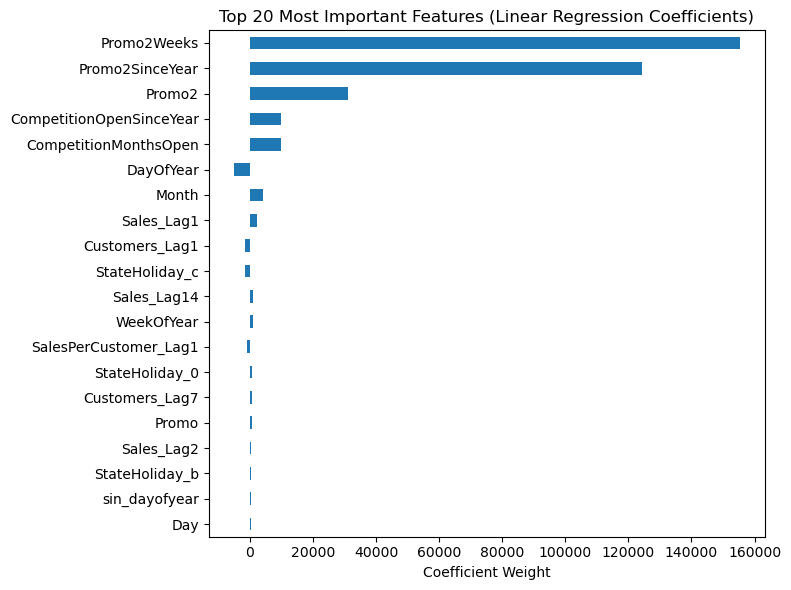

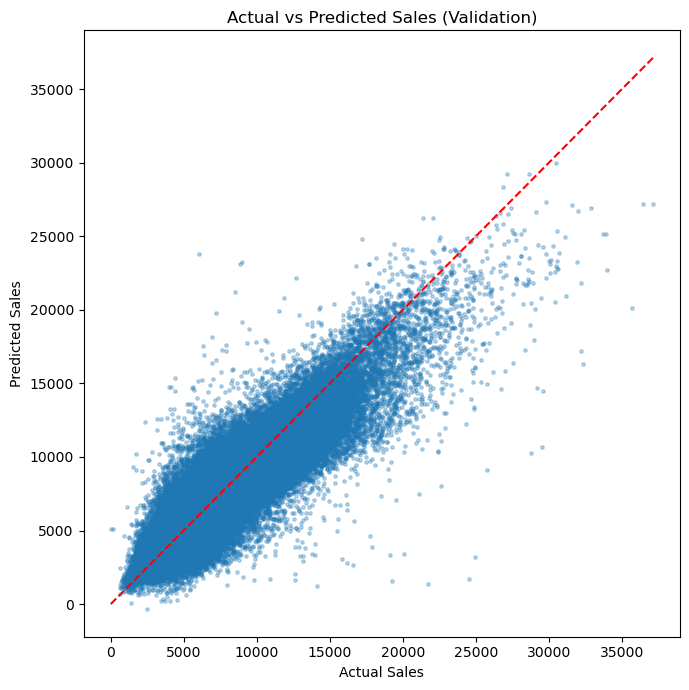

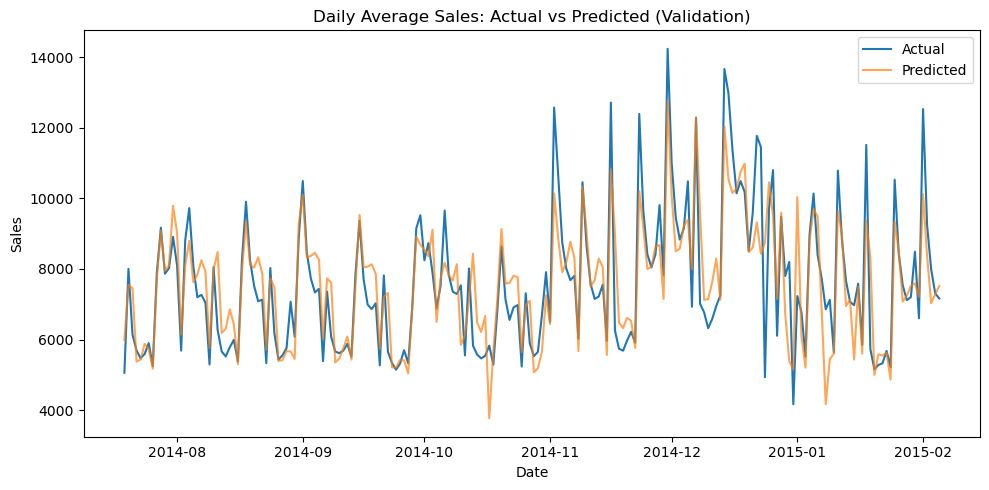

In [20]:
# train model
linreg = LinearRegression()
linreg.fit(X_train_prep, y_train)

# predictions
y_pred_train = linreg.predict(X_train_prep)
y_pred_val   = linreg.predict(X_val_prep)

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_val_lr   = np.sqrt(mean_squared_error(y_val, y_pred_val))

print(f"RMSE Train: {rmse_train:.2f}")
print(f"RMSE Val:   {rmse_val_lr:.2f}")

# feature importance (coefficients)
ohe = preprocessor.named_transformers_["cat"].named_steps["ohe"] if len(cat_features) else None
cat_names = ohe.get_feature_names_out(cat_features) if ohe is not None else np.array([])
all_feature_names = np.concatenate([cat_names, np.array(num_features)])

coefs = pd.Series(linreg.coef_, index=all_feature_names).sort_values(key=np.abs, ascending=False)
topN = 20
plt.figure(figsize=(8,6))
coefs.head(topN).plot(kind="barh")
plt.title(f"Top {topN} Most Important Features (Linear Regression Coefficients)")
plt.gca().invert_yaxis()
plt.xlabel("Coefficient Weight")
plt.tight_layout()
plt.show()

# actual vs predicted (scatter)
plt.figure(figsize=(7,7))
plt.scatter(y_val, y_pred_val, s=6, alpha=0.3)
plt.plot([0, y_val.max()], [0, y_val.max()], color='red', linestyle='--')
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Sales (Validation)")
plt.tight_layout()
plt.show()

# trend over time
val_idx = val.index

val_df = rossman_df.loc[val_idx, ["Date", "Sales"]].copy()
val_df["Predicted"] = pd.Series(y_pred_val, index=val_idx).values  # довжини збігаються

daily = val_df.groupby("Date")[["Sales","Predicted"]].mean()

plt.figure(figsize=(10,5))
plt.plot(daily.index, daily["Sales"], label="Actual")
plt.plot(daily.index, daily["Predicted"], label="Predicted", alpha=0.7)
plt.title("Daily Average Sales: Actual vs Predicted (Validation)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()

## Логістична регресія

Median Sales (train): 6281.00


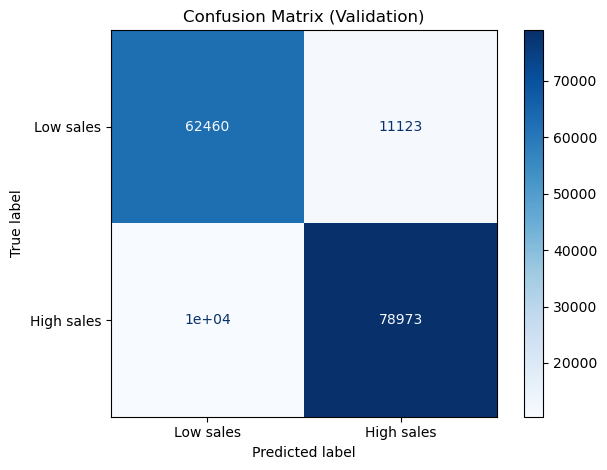

Accuracy : 0.868
Precision: 0.877
Recall   : 0.883
F1-score : 0.880


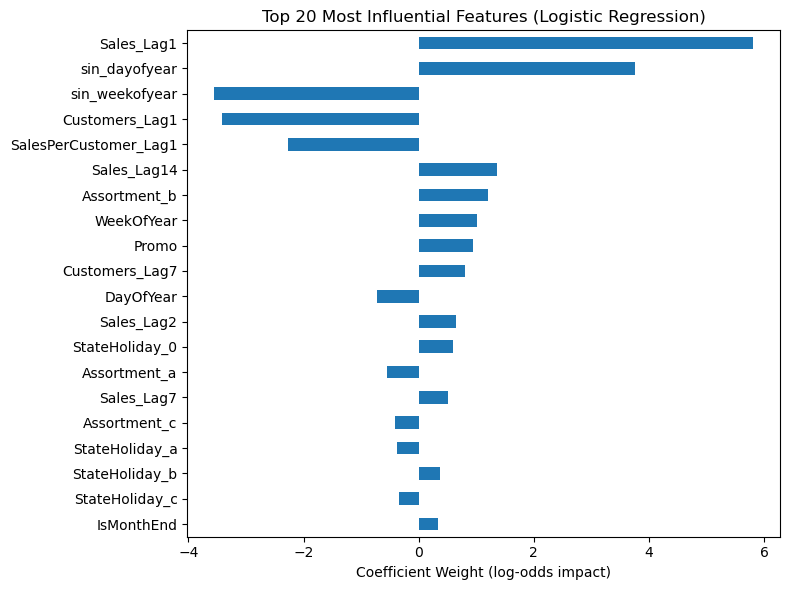

In [21]:
# Create binary target variable
median_sales = np.median(y_train)
print(f"Median Sales (train): {median_sales:.2f}")

y_train_bin = (y_train > median_sales).astype(int)
y_val_bin   = (y_val > median_sales).astype(int)

# Train Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_prep, y_train_bin)

# Prediction and probabilities
y_pred_val = log_model.predict(X_val_prep)
y_proba_val = log_model.predict_proba(X_val_prep)[:, 1]

# Confusion matrix
cm = confusion_matrix(y_val_bin, y_pred_val)
disp = ConfusionMatrixDisplay(cm, display_labels=["Low sales", "High sales"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Validation)")
plt.tight_layout()
plt.show()

# Quality scores
acc  = accuracy_score(y_val_bin, y_pred_val)
prec = precision_score(y_val_bin, y_pred_val)
rec  = recall_score(y_val_bin, y_pred_val)
f1   = f1_score(y_val_bin, y_pred_val)

print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1-score : {f1:.3f}")

# Features importance (coefficients)
ohe = preprocessor.named_transformers_["cat"].named_steps["ohe"] if len(cat_features) else None
cat_names = ohe.get_feature_names_out(cat_features) if ohe is not None else np.array([])
feat_names = np.concatenate([cat_names, np.array(num_features)])

coefs = pd.Series(log_model.coef_[0], index=feat_names).sort_values(key=np.abs, ascending=False)
plt.figure(figsize=(8,6))
coefs.head(20).plot(kind="barh")
plt.title("Top 20 Most Influential Features (Logistic Regression)")
plt.gca().invert_yaxis()
plt.xlabel("Coefficient Weight (log-odds impact)")
plt.tight_layout()
plt.show()

## Дерево рішень


Top 5 combinations:
    max_depth  min_samples_split     RMSE_val
12         10                  2  1418.153713
15         10                 20  1419.362617
14         10                 10  1435.471305
13         10                  5  1437.448219
19         15                 20  1501.653808

Best model parameters: {'max_depth': 10, 'min_samples_split': 2}, RMSE=1418.15

RMSE Train: 1019.50
RMSE Val:   1418.15


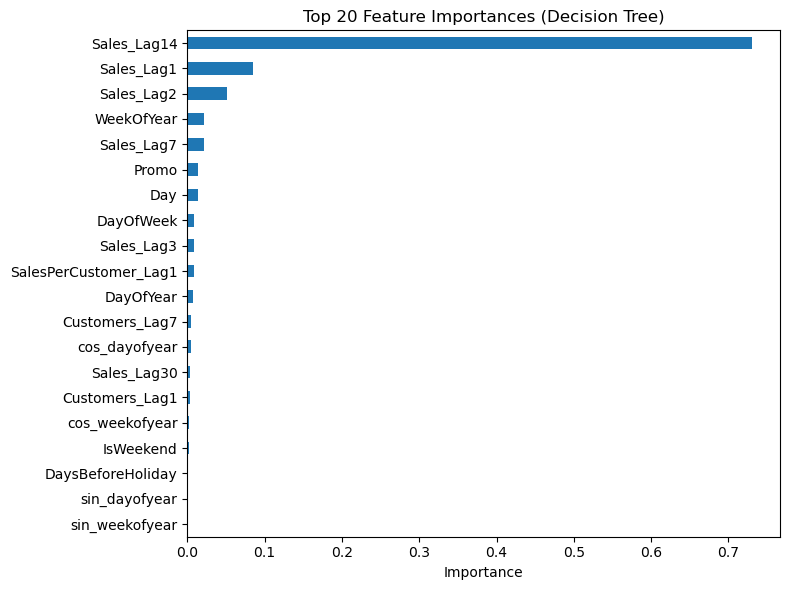

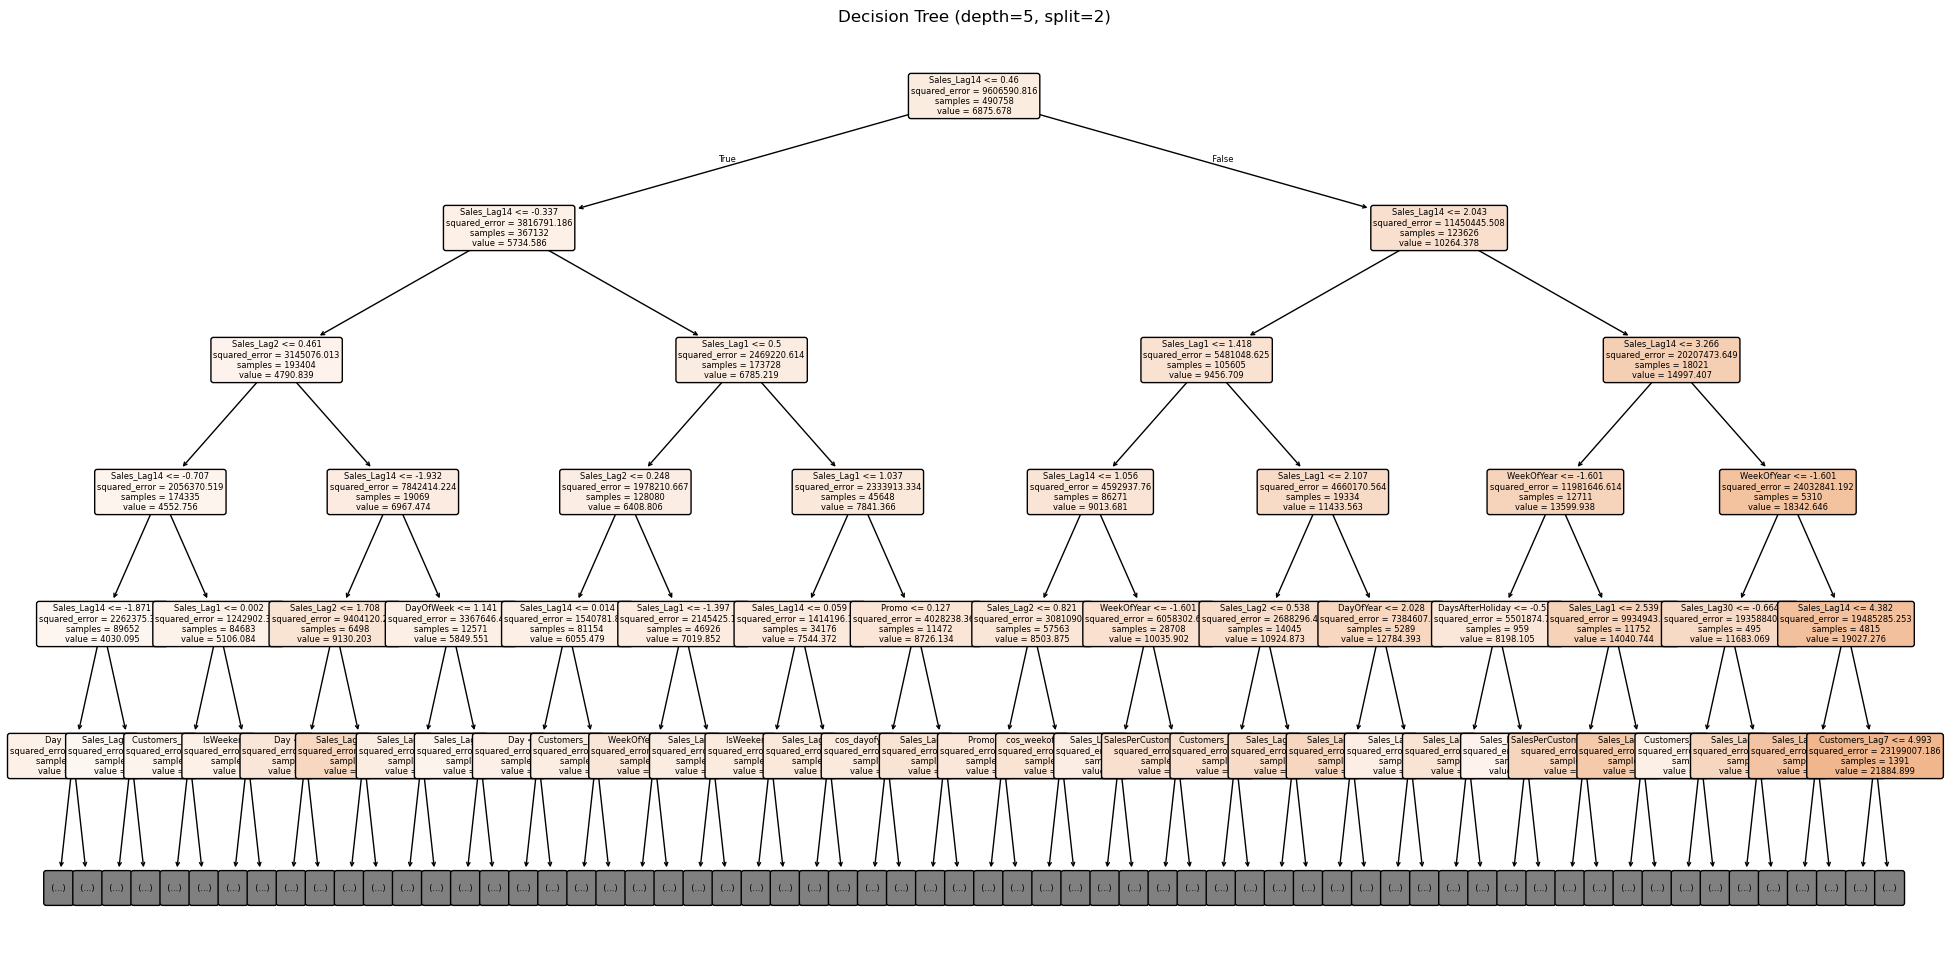


Text visualization:

|--- Sales_Lag14 <= 0.46
|   |--- Sales_Lag14 <= -0.34
|   |   |--- Sales_Lag2 <= 0.46
|   |   |   |--- Sales_Lag14 <= -0.71
|   |   |   |   |--- Sales_Lag14 <= -1.87
|   |   |   |   |   |--- Day <= -0.82
|   |   |   |   |   |   |--- Sales_Lag7 <= 0.43
|   |   |   |   |   |   |   |--- Sales_Lag1 <= 1.33
|   |   |   |   |   |   |   |   |--- Sales_Lag7 <= -0.12
|   |   |   |   |   |   |   |   |   |--- DaysAfterHoliday <= -0.96
|   |   |   |   |   |   |   |   |   |   |--- value: [6620.80]
|   |   |   |   |   |   |   |   |   |--- DaysAfterHoliday >  -0.96
|   |   |   |   |   |   |   |   |   |   |--- value: [5420.40]
|   |   |   |   |   |   |   |   |--- Sales_Lag7 >  -0.12
|   |   |   |   |   |   |   |   |   |--- Sales_Lag3 <= 0.27
|   |   |   |   |   |   |   |   |   |   |--- value: [6429.04]
|   |   |   |   |   |   |   |   |   |--- Sales_Lag3 >  0.27
|   |   |   |   |   |   |   |   |   |   |--- value: [7476.20]
|   |   |   |   |   |   |   |--- Sales_Lag1 >  1.33
|   |

In [22]:
# Hyperparameters for experiments
param_grid = {
    "max_depth": [3, 5, 7, 10, 15],
    "min_samples_split": [2, 5, 10, 20],
}

results = []

# Check all combinations of params
for params in ParameterGrid(param_grid):
    model = DecisionTreeRegressor(**params, random_state=42)
    model.fit(X_train_prep, y_train)
    y_pred_val = model.predict(X_val_prep)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
    results.append({"params": params, "RMSE_val": rmse_val})

# Summary of results
results_df = pd.DataFrame([
    {
        "max_depth": r["params"]["max_depth"],
        "min_samples_split": r["params"]["min_samples_split"],
        "RMSE_val": r["RMSE_val"],
    } for r in results
]).sort_values("RMSE_val")

print("\nTop 5 combinations:")
print(results_df.head())

# Best model
best_run = min(results, key=lambda d: d["RMSE_val"])
best_params_dt = best_run["params"]
print(f"\nBest model parameters: {best_params_dt}, RMSE={best_run['RMSE_val']:.2f}")

# Train final model with best params ---
final_tree = DecisionTreeRegressor(**best_params_dt, random_state=42)
final_tree.fit(X_train_prep, y_train)

y_pred_train = final_tree.predict(X_train_prep)
y_pred_val   = final_tree.predict(X_val_prep)

# RMSE for train/val
y_pred_train = final_tree.predict(X_train_prep)
y_pred_val   = final_tree.predict(X_val_prep)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_val_dt   = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"\nRMSE Train: {rmse_train:.2f}")
print(f"RMSE Val:   {rmse_val_dt:.2f}")

# Features importance
# get features names
try:
    ohe = preprocessor.named_transformers_["cat"].named_steps["ohe"]
    cat_names = ohe.get_feature_names_out(cat_features)
except Exception:
    cat_names = []
feat_names = np.concatenate([cat_names, np.array(num_features)])

importances = pd.Series(final_tree.feature_importances_, index=feat_names).sort_values(ascending=False)

plt.figure(figsize=(8,6))
importances.head(20).plot(kind="barh")
plt.title("Top 20 Feature Importances (Decision Tree)")
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# Tree visualization
plt.figure(figsize=(24, 12))
plot_tree(
    final_tree,
    feature_names=feat_names,
    filled=True,
    rounded=True,
    fontsize=6,
    max_depth=5
)
plt.title(f"Decision Tree (depth=5, split={final_tree.min_samples_split})")
plt.show()

# Text visualization
print(f"\nText visualization:\n")
tree_text = export_text(final_tree, max_depth=final_tree.max_depth, feature_names=feat_names)
print(tree_text[:5000])

# Comparison with LinearRegression (by coefficients)
if 'coefs' in locals():
    compare_df = pd.DataFrame({
        "LinearRegression": coefs.abs(),
        "DecisionTree": importances
    }).fillna(0)
    compare_df["Diff"] = compare_df["DecisionTree"] - compare_df["LinearRegression"]
    print("\nTop 10 features — importance comparison:")
    print(compare_df.sort_values("DecisionTree", ascending=False).head(10))

## Random Forest


Top 5 parameter combinations:
    n_estimators max_depth max_features     RMSE_val
17           100       NaN          0.5  1041.446899
16            50       NaN          0.5  1052.241773
13           100       NaN         sqrt  1064.515018
12            50       NaN         sqrt  1081.737768
15           100       NaN         log2  1084.967698

Best model parameters: {'max_depth': None, 'max_features': 0.5, 'n_estimators': 100}, RMSE=1041.45

RMSE Train: 273.61
RMSE Val:   1041.45

Top 10 most important features:
Sales_Lag14              0.440623
Sales_Lag1               0.178391
Sales_Lag2               0.092534
Sales_Lag3               0.051354
Sales_Lag7               0.038884
Promo                    0.026220
Customers_Lag1           0.020252
Customers_Lag7           0.019627
SalesPerCustomer_Lag1    0.015618
Day                      0.014597
dtype: float64


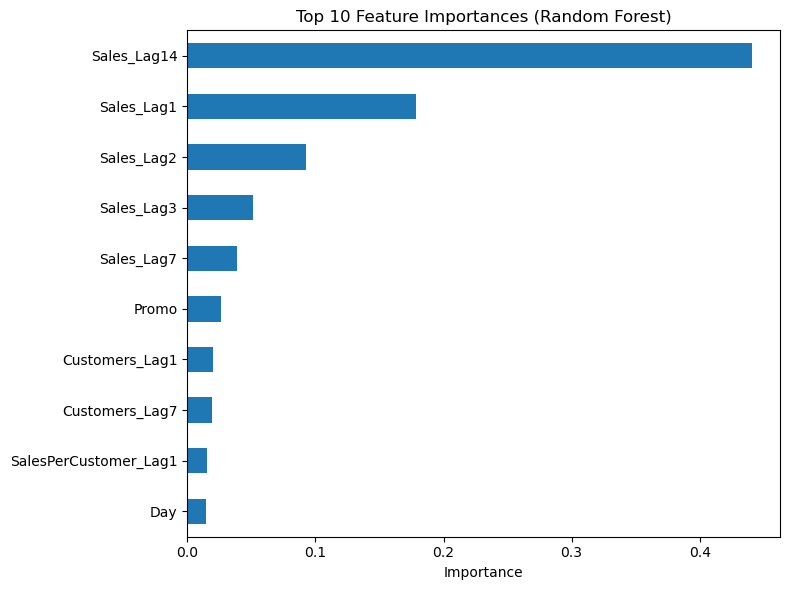


=== Model Comparison (Validation RMSE) ===
Linear Regression : 1457.08
Decision Tree      : 1418.15
Random Forest      : 1041.45


In [23]:
# specify the parameter grid as a dictionary
param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [5, 10, None],
    "max_features": ["sqrt", "log2", 0.5],
}

results = []  # for saving the results

# check all combinations (time consume operation)
for params in ParameterGrid(param_grid):
    rf = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
    rf.fit(X_train_prep, y_train)
    y_pred_val = rf.predict(X_val_prep)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
    results.append({"params": params, "RMSE_val": rmse_val})

# make a DataFrame for convenient output
rf_results = pd.DataFrame([{
    "n_estimators": r["params"]["n_estimators"],
    "max_depth": r["params"]["max_depth"],
    "max_features": r["params"]["max_features"],
    "RMSE_val": r["RMSE_val"],
} for r in results]).sort_values("RMSE_val")
rf_results["max_depth"] = rf_results["max_depth"].astype("object")

print("\nTop 5 parameter combinations:")
print(rf_results.head())

# choose the best result (RMSE minimum)
best_run = min(results, key=lambda d: d["RMSE_val"])
best_params_rf = best_run["params"]
print(f"\nBest model parameters: {best_params_rf}, RMSE={best_run['RMSE_val']:.2f}")

# Let's train the final model with the best parameters
best_rf = RandomForestRegressor(**best_params_rf, random_state=42, n_jobs=-1)
best_rf.fit(X_train_prep, y_train)

# RMSE Train / Validation
y_pred_train = best_rf.predict(X_train_prep)
y_pred_val   = best_rf.predict(X_val_prep)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_val_rf   = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"\nRMSE Train: {rmse_train:.2f}")
print(f"RMSE Val:   {rmse_val_rf:.2f}")

# Features importance
try:
    ohe = preprocessor.named_transformers_["cat"].named_steps["ohe"]
    cat_names = ohe.get_feature_names_out(cat_features)
except Exception:
    cat_names = []
feat_names = np.concatenate([cat_names, np.array(num_features)])

importances = pd.Series(best_rf.feature_importances_, index=feat_names).sort_values(ascending=False)

print("\nTop 10 most important features:")
print(importances.head(10))

plt.figure(figsize=(8,6))
importances.head(10).plot(kind="barh")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# Comparison with Decision Tree and Linear Regression
print("\n=== Model Comparison (Validation RMSE) ===")
print(f"Linear Regression : {rmse_val_lr:.2f}" if 'rmse_val_lr' in locals() else "Linear Regression : (not computed)")
print(f"Decision Tree      : {rmse_val_dt:.2f}" if 'rmse_val_dt' in locals() else "Decision Tree      : (not computed)")
print(f"Random Forest      : {rmse_val_rf:.2f}")

## Оцінка та вибір моделі


⏳ Training LinearRegression...

⏳ Training DecisionTree...

⏳ Training RandomForest...

=== Model Comparison ===
           Model  RMSE_train  RMSE_val  RMSE_test  Train_time_s  Predict_time_s
    RandomForest      273.61  1,041.45     890.72        228.97            7.94
    DecisionTree    1,019.50  1,418.15   1,183.36         18.76            0.22
LinearRegression    1,394.26  1,457.08   1,315.76          3.77            1.06

Best model by the RMSE(validation): RandomForest


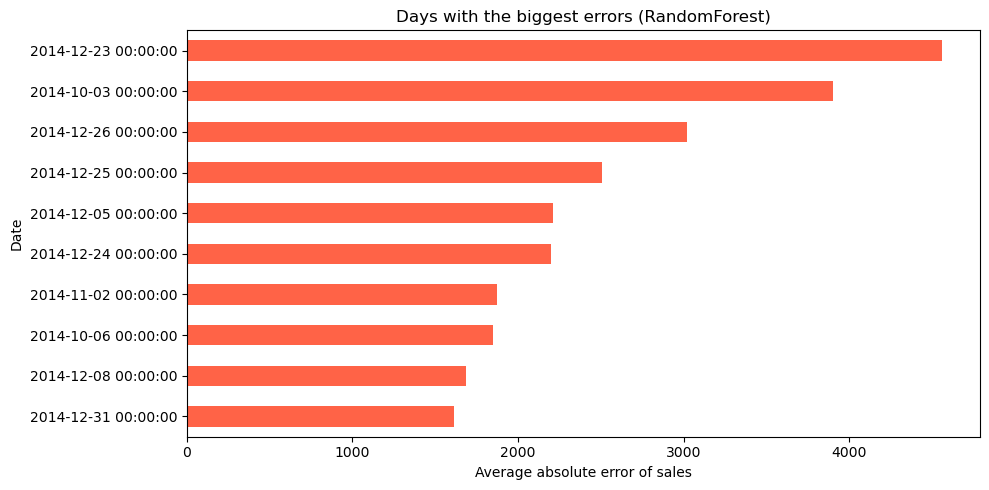


Top 10 days with the biggest mistakes:
Date
2014-12-23    4561.658417
2014-10-03    3902.643077
2014-12-26    3020.593684
2014-12-25    2507.001250
2014-12-05    2208.717818
2014-12-24    2201.567679
2014-11-02    1874.897647
2014-10-06    1848.238845
2014-12-08    1687.401412
2014-12-31    1615.449786
Name: AbsError, dtype: float64


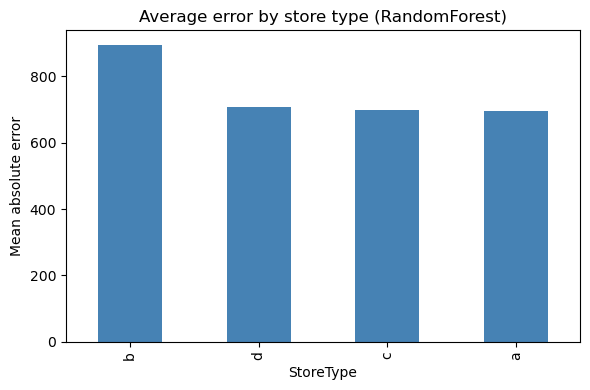


Average error by store type:
StoreType
b    894.254419
d    708.502179
c    699.518387
a    694.647861
Name: AbsError, dtype: float64


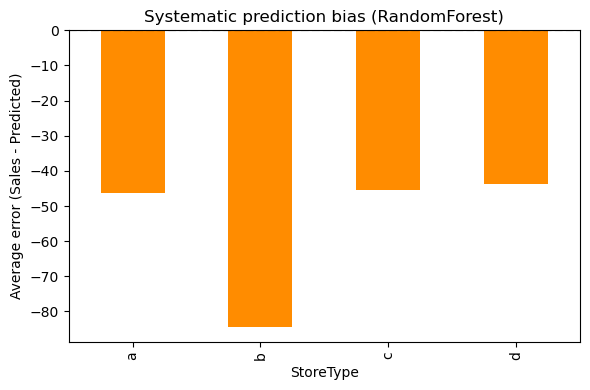


Average error (Sales - Predicted) by store type:
StoreType
a   -46.215544
b   -84.429816
c   -45.569860
d   -43.780072
Name: Error, dtype: float64


In [24]:
# Defining models
models = {
    "LinearRegression": LinearRegression(),
    "DecisionTree": DecisionTreeRegressor(max_depth=final_tree.get_params()["max_depth"], 
                                          min_samples_split=final_tree.get_params()["min_samples_split"], 
                                          random_state=42),
    "RandomForest": RandomForestRegressor(**best_rf.get_params())
}

results = []

# Training, prediction, metrics, timings
for name, model in models.items():
    print(f"\n⏳ Training {name}...")
    t0 = time.time()
    model.fit(X_train_prep, y_train)
    train_time = time.time() - t0

    t1 = time.time()
    y_pred_train = model.predict(X_train_prep)
    y_pred_val   = model.predict(X_val_prep)
    y_pred_test  = model.predict(X_test_prep)
    predict_time = time.time() - t1

    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_val   = np.sqrt(mean_squared_error(y_val,   y_pred_val))
    rmse_test  = np.sqrt(mean_squared_error(y_test,  y_pred_test))

    results.append({
        "Model": name,
        "RMSE_train": rmse_train,
        "RMSE_val": rmse_val,
        "RMSE_test": rmse_test,
        "Train_time_s": train_time,
        "Predict_time_s": predict_time
    })

# Model comparison table
results_df = pd.DataFrame(results).sort_values("RMSE_val")
print("\n=== Model Comparison ===")
print(results_df.to_string(index=False, float_format=lambda x: f"{x:,.2f}"))

best_model_name = results_df.iloc[0]["Model"]
print(f"\nBest model by the RMSE(validation): {best_model_name}")

best_model = models[best_model_name]

# Error analysis of the best model
# get predictions for validation
y_pred_val_best = best_model.predict(X_val_prep)
val_errors = y_val - y_pred_val_best

val_with_err = val.copy()
val_with_err["Error"] = val_errors
val_with_err["AbsError"] = np.abs(val_errors)
val_with_err["Predicted"] = y_pred_val_best

# days with the largest errors (average absolute error by day)
day_err = val_with_err.groupby("Date")["AbsError"].mean().sort_values(ascending=False)
top_days = day_err.head(10)

plt.figure(figsize=(10,5))
top_days.sort_values().plot(kind="barh", color="tomato")
plt.title(f"Days with the biggest errors ({best_model_name})")
plt.xlabel("Average absolute error of sales")
plt.tight_layout()
plt.show()

print("\nTop 10 days with the biggest mistakes:")
print(top_days)

# systematic errors for store types
if "StoreType" in val_with_err.columns:
    type_err = val_with_err.groupby("StoreType")["AbsError"].mean().sort_values(ascending=False)
    plt.figure(figsize=(6,4))
    type_err.plot(kind="bar", color="steelblue")
    plt.title(f"Average error by store type ({best_model_name})")
    plt.ylabel("Mean absolute error")
    plt.tight_layout()
    plt.show()

    print("\nAverage error by store type:")
    print(type_err)

# systematic error (underestimation/overestimation)
if "StoreType" in val_with_err.columns:
    bias_by_type = val_with_err.groupby("StoreType")["Error"].mean()
    plt.figure(figsize=(6,4))
    bias_by_type.plot(kind="bar", color="darkorange")
    plt.title(f"Systematic prediction bias ({best_model_name})")
    plt.ylabel("Average error (Sales - Predicted)")
    plt.axhline(0, color="black", linestyle="--")
    plt.tight_layout()
    plt.show()

    print("\nAverage error (Sales - Predicted) by store type:")
    print(bias_by_type)


## Збереження і завантаження моделей

In [25]:
MODELS_DIR = Path("./models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)

def save_model_bundle(
    name: str,
    model,
    preprocessor,
    cat_features: list,
    num_features: list,
    task_type: str,               # 'regression' | 'classification'
    extra_meta: dict = None
) -> Path:
    """
    Stores a set of model artifacts:
      - model.joblib
      - preprocessor.joblib
      - meta.json (column lists, task type, versions, etc.)
    Returns the path to the bundle folder.
    """
    bundle_dir = MODELS_DIR / name
    bundle_dir.mkdir(parents=True, exist_ok=True)

    # 1) model and preprocessor
    joblib.dump(model, bundle_dir / "model.joblib")
    joblib.dump(preprocessor, bundle_dir / "preprocessor.joblib")

    # 2) meta.json
    meta = {
        "name": name,
        "task_type": task_type,
        "cat_features": list(cat_features),
        "num_features": list(num_features),
    }
    if extra_meta:
        meta.update(extra_meta)

    with open(bundle_dir / "meta.json", "w", encoding="utf-8") as f:
        json.dump(meta, f, ensure_ascii=False, indent=2)

    print(f"[SAVED] Bundle: {bundle_dir}")
    return bundle_dir


def load_model_bundle(name: str):
    """
    Loads a set of model artifacts:
      - model
      - preprocessor
      - meta (dictionary)
    """
    bundle_dir = MODELS_DIR / name
    model = joblib.load(bundle_dir / "model.joblib")
    preprocessor = joblib.load(bundle_dir / "preprocessor.joblib")
    with open(bundle_dir / "meta.json", "r", encoding="utf-8") as f:
        meta = json.load(f)
    print(f"[LOADED] Bundle: {bundle_dir}")
    return model, preprocessor, meta


def predict_from_raw(raw_df: pd.DataFrame, preprocessor, meta: dict):
    """
    Takes a 'raw' DataFrame with the same columns as in training,
    forms X in the same order (cat + num), transforms it with a preprocessor,
    returns X_prep (for transparency) and y_hat.
    """
    expected_cols = list(meta["cat_features"]) + list(meta["num_features"])
    missing = [c for c in expected_cols if c not in raw_df.columns]
    if missing:
        raise ValueError(f"Expected columns are missing: {missing}")

    X_raw = raw_df[expected_cols].copy()
    X_prep = preprocessor.transform(X_raw)
    return X_prep

In [26]:
# 1) Linear Regression (regression)
save_model_bundle(
    name="linear_regression",
    model=linreg,
    preprocessor=preprocessor,
    cat_features=cat_features,
    num_features=num_features,
    task_type="regression"
)

# 2) Logistic Regression (classification)
save_model_bundle(
    name="logistic_regression",
    model=log_model,
    preprocessor=preprocessor,
    cat_features=cat_features,
    num_features=num_features,
    task_type="classification",
    extra_meta={"positive_label": "HighSales"}  # просто для інформації
)

# 3) Decision Tree Regressor (regression)
save_model_bundle(
    name="decision_tree",
    model=final_tree,
    preprocessor=preprocessor,
    cat_features=cat_features,
    num_features=num_features,
    task_type="regression"
)

# 4) Random Forest Regressor (regression)
save_model_bundle(
    name="random_forest",
    model=best_rf,
    preprocessor=preprocessor,
    cat_features=cat_features,
    num_features=num_features,
    task_type="regression"
)

[SAVED] Bundle: models\linear_regression
[SAVED] Bundle: models\logistic_regression
[SAVED] Bundle: models\decision_tree
[SAVED] Bundle: models\random_forest


WindowsPath('models/random_forest')

## Валідація

In [27]:
# For regressions — RMSE on validation
# For classification — Accuracy / Precision / Recall / F1

def eval_regression_bundle(bundle_name: str, val_df: pd.DataFrame, y_val: np.ndarray):
    model, preproc, meta = load_model_bundle(bundle_name)
    X_val_prep = predict_from_raw(val_df, preproc, meta)
    y_hat = model.predict(X_val_prep)
    rmse = np.sqrt(mean_squared_error(y_val, y_hat))
    print(f"[{bundle_name}] Validation RMSE: {rmse:.3f}")
    return rmse

def eval_classification_bundle(bundle_name: str, val_df: pd.DataFrame, y_val_bin: np.ndarray):
    model, preproc, meta = load_model_bundle(bundle_name)
    X_val_prep = predict_from_raw(val_df, preproc, meta)
    y_pred = model.predict(X_val_prep)
    acc  = accuracy_score(y_val_bin, y_pred)
    prec = precision_score(y_val_bin, y_pred)
    rec  = recall_score(y_val_bin, y_pred)
    f1   = f1_score(y_val_bin, y_pred)
    print(f"[{bundle_name}] Acc={acc:.3f}  Prec={prec:.3f}  Rec={rec:.3f}  F1={f1:.3f}")
    return acc, prec, rec, f1

In [28]:
# Validation checks
print("\n=== Load & Verify ===")
rmse_lin  = eval_regression_bundle("linear_regression", val, y_val)
rmse_tree = eval_regression_bundle("decision_tree",   val, y_val)
rmse_rf   = eval_regression_bundle("random_forest",   val, y_val)

acc, prec, rec, f1 = eval_classification_bundle("logistic_regression", val, y_val_bin)

print("\n=== Summary ===")
print(f"Linear Regression  RMSE: {rmse_lin:.3f}")
print(f"Decision Tree      RMSE: {rmse_tree:.3f}")
print(f"Random Forest      RMSE: {rmse_rf:.3f}")
print(f"Logistic Regression Acc={acc:.3f}  Prec={prec:.3f}  Rec={rec:.3f}  F1={f1:.3f}")


=== Load & Verify ===
[LOADED] Bundle: models\linear_regression
[linear_regression] Validation RMSE: 1457.078
[LOADED] Bundle: models\decision_tree
[decision_tree] Validation RMSE: 1418.154
[LOADED] Bundle: models\random_forest
[random_forest] Validation RMSE: 1041.447
[LOADED] Bundle: models\logistic_regression
[logistic_regression] Acc=0.868  Prec=0.877  Rec=0.883  F1=0.880

=== Summary ===
Linear Regression  RMSE: 1457.078
Decision Tree      RMSE: 1418.154
Random Forest      RMSE: 1041.447
Logistic Regression Acc=0.868  Prec=0.877  Rec=0.883  F1=0.880
